## Import Tools

In [1]:
import torch
import numpy as np
import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
import torch.nn as nn
import torch.optim as optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Neural_Network/project_1/'

Mounted at /content/drive


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cpu


## Dataset Processing

### Read in the original dataset

In [4]:
train_dl_origin = torch.load(path + 'train_dl.pt', weights_only=False)
valid_dl_origin = torch.load(path + 'valid_dl.pt', weights_only=False)

train_CSI = train_dl_origin.dataset[:][0]
train_label_full = train_dl_origin.dataset[:][1]    #[:,2].type(torch.LongTensor)

valid_CSI = valid_dl_origin.dataset[:][0]
valid_label_full = valid_dl_origin.dataset[:][1]    #[:,2].type(torch.LongTensor)

### CSI Processing: Take Modulus of complex matrices

In [5]:
train_CSI_mod = torch.abs(train_CSI)
valid_CSI_mod = torch.abs(valid_CSI)
print(train_CSI_mod.shape)
print(valid_CSI_mod.shape)

torch.Size([15000, 1, 4, 1632])
torch.Size([5000, 1, 4, 1632])


In [6]:
# Flatten each CSI matrix (4 x 1632) → (6528,)
train_X = train_CSI_mod.view(train_CSI_mod.shape[0], -1).numpy()
valid_X = valid_CSI_mod.view(valid_CSI_mod.shape[0], -1).numpy()
train_X.shape, valid_X.shape

((15000, 6528), (5000, 6528))

In [7]:
# Extract labels
train_y = train_label_full[:, 2].numpy().astype(int)   # LoS/NLoS classification
valid_y = valid_label_full[:, 2].numpy().astype(int)

In [8]:
# Normalize features
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
valid_X_scaled = scaler.transform(valid_X)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.12/dist-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


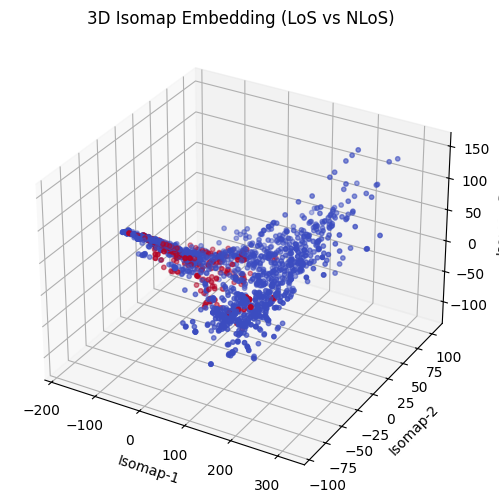

In [9]:
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

isomap = Isomap(n_neighbors=10, n_components=3)
embed = isomap.fit_transform(train_X_scaled[:2000])

plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')
ax.scatter(embed[:,0], embed[:,1], embed[:,2],
           c=train_y[:2000], cmap='coolwarm', s=10)
ax.set_xlabel('Isomap-1')
ax.set_ylabel('Isomap-2')
ax.set_zlabel('Isomap-3')
ax.set_title('3D Isomap Embedding (LoS vs NLoS)')
plt.show()

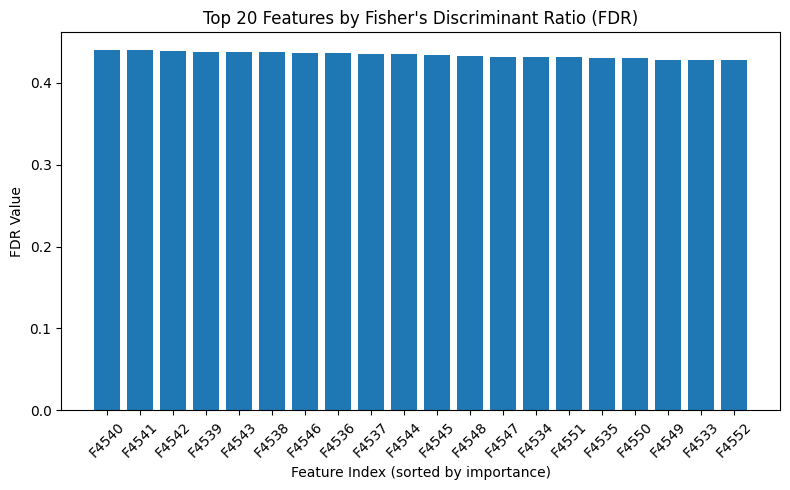


Top 20 features by Fisher’s Discriminant Ratio:
    Feature_Index  FDR_Value
0            4540   0.439543
1            4541   0.439433
2            4542   0.438890
3            4539   0.438115
4            4543   0.438013
5            4538   0.437121
6            4546   0.436825
7            4536   0.435791
8            4537   0.435304
9            4544   0.435168
10           4545   0.433703
11           4548   0.433011
12           4547   0.431578
13           4534   0.431382
14           4551   0.431035
15           4535   0.430431
16           4550   0.429998
17           4549   0.427563
18           4533   0.427230
19           4552   0.427142

KMeans Clustering Results:
Adjusted Rand Index (ARI): 0.0403
Silhouette Score: 0.6695


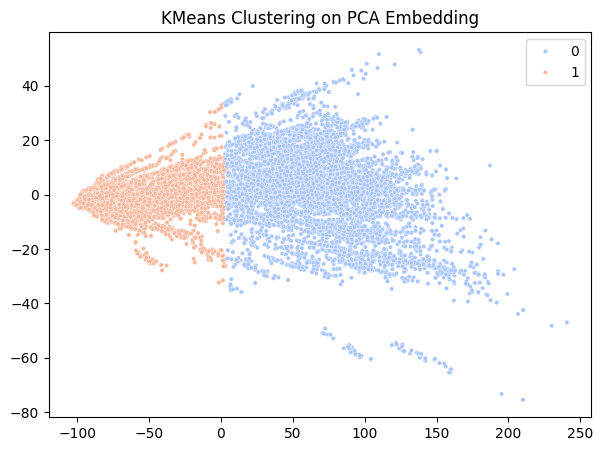


DBSCAN Clustering Results:
Adjusted Rand Index (ARI): 0.0471
Silhouette Score: 0.4671


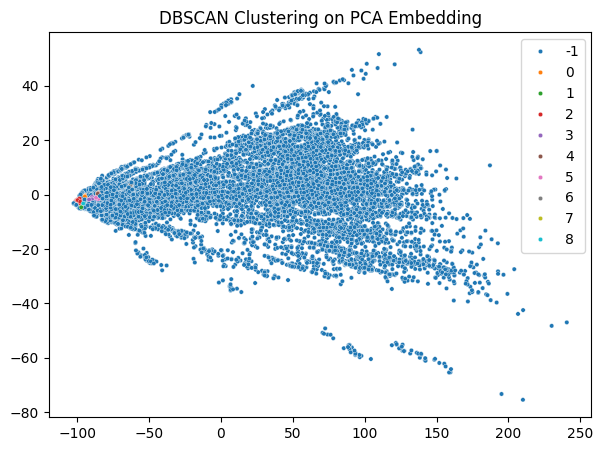

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score

# Compute FDR per feature
def compute_fdr(X, y):
    fdr_values = []
    X = np.asarray(X)
    for j in range(X.shape[1]):
        feat = X[:, j]
        class0 = feat[y == 0]
        class1 = feat[y == 1]
        mu0, mu1 = np.mean(class0), np.mean(class1)
        var0, var1 = np.var(class0), np.var(class1)
        fdr = (mu1 - mu0) ** 2 / (var1 + var0 + 1e-8)
        fdr_values.append(fdr)
    return np.array(fdr_values)

fdr_scores = compute_fdr(train_X_scaled, train_y)
fdr_rank = np.argsort(fdr_scores)[::-1]

# Plot top 20 FDR-ranked features
top_k = 20
plt.figure(figsize=(8,5))
plt.bar(range(top_k), fdr_scores[fdr_rank[:top_k]])
plt.xticks(range(top_k), [f"F{idx}" for idx in fdr_rank[:top_k]], rotation=45)
#plt.xticks(range(top_k), f"F{fdr_rank[:top_k]}")
plt.title("Top 20 Features by Fisher's Discriminant Ratio (FDR)")
plt.ylabel("FDR Value")
plt.xlabel("Feature Index (sorted by importance)")
plt.tight_layout()
plt.show()

# Log summary DataFrame
fdr_df = pd.DataFrame({
    "Feature_Index": fdr_rank[:top_k],
    "FDR_Value": fdr_scores[fdr_rank[:top_k]]
})
print("\nTop 20 features by Fisher’s Discriminant Ratio:")
print(fdr_df)

from sklearn.decomposition import PCA

# Reduce data to 2D for visualization
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(train_X_scaled)

# ---------- KMeans ----------
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca_2d)

ari_kmeans = adjusted_rand_score(train_y, kmeans_labels)
sil_kmeans = silhouette_score(X_pca_2d, kmeans_labels)

print(f"\nKMeans Clustering Results:")
print(f"Adjusted Rand Index (ARI): {ari_kmeans:.4f}")
print(f"Silhouette Score: {sil_kmeans:.4f}")

plt.figure(figsize=(7,5))
sns.scatterplot(x=X_pca_2d[:,0], y=X_pca_2d[:,1], hue=kmeans_labels, palette='coolwarm', s=10)
plt.title("KMeans Clustering on PCA Embedding")
plt.show()

# ---------- DBSCAN ----------
dbscan = DBSCAN(eps=0.5, min_samples=30)
db_labels = dbscan.fit_predict(X_pca_2d)

# Remove noise label (-1) for scoring
mask = db_labels != -1
if np.unique(db_labels[mask]).size > 1:
    ari_dbscan = adjusted_rand_score(train_y[mask], db_labels[mask])
    sil_dbscan = silhouette_score(X_pca_2d[mask], db_labels[mask])
    print(f"\nDBSCAN Clustering Results:")
    print(f"Adjusted Rand Index (ARI): {ari_dbscan:.4f}")
    print(f"Silhouette Score: {sil_dbscan:.4f}")
else:
    print("\nDBSCAN found less than 2 clusters; ARI/Silhouette not defined.")

plt.figure(figsize=(7,5))
sns.scatterplot(x=X_pca_2d[:,0], y=X_pca_2d[:,1], hue=db_labels, palette='tab10', s=10)
plt.title("DBSCAN Clustering on PCA Embedding")
plt.show()

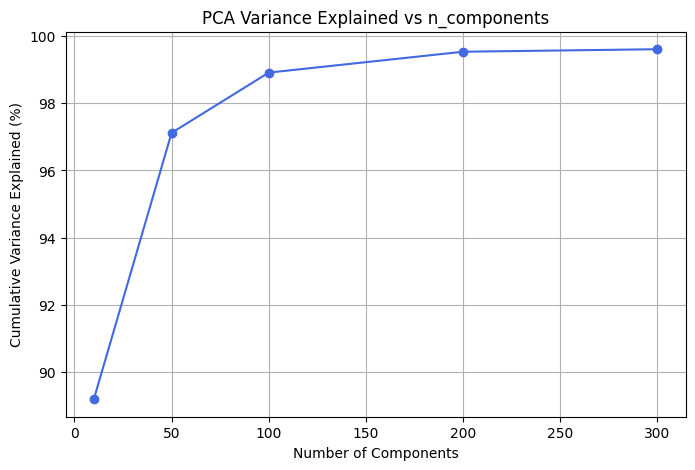

In [15]:
import matplotlib.pyplot as plt

n_components_list = [10, 50, 100, 200, 300]
explained_variance = []

for n in n_components_list:
    pca = PCA(n_components=n)
    pca.fit(train_X_scaled)
    var = np.sum(pca.explained_variance_ratio_)
    explained_variance.append(var)

plt.figure(figsize=(8,5))
plt.plot(n_components_list, np.array(explained_variance)*100, 'o-', color='royalblue')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained (%)')
plt.title('PCA Variance Explained vs n_components')
plt.grid(True)
plt.show()

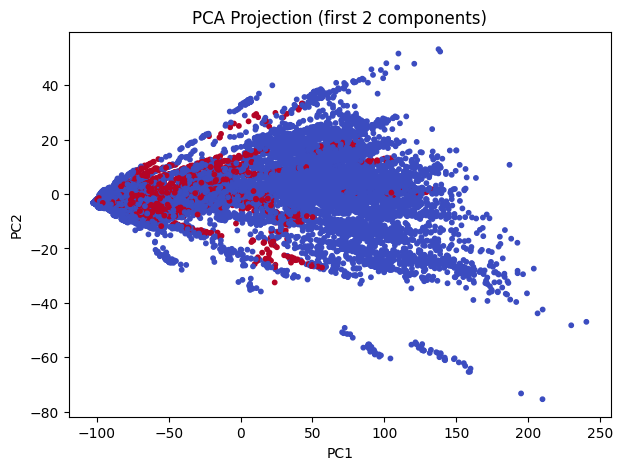

In [16]:
# Optimal n_components
best_n = 100
pca = PCA(n_components=best_n)
train_pca = pca.fit_transform(train_X_scaled)
valid_pca = pca.transform(valid_X_scaled)

# 2D Projection for separability visualization
plt.figure(figsize=(7,5))
plt.scatter(train_pca[:,0], train_pca[:,1], c=train_y, cmap='coolwarm', s=10)
plt.title('PCA Projection (first 2 components)')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()




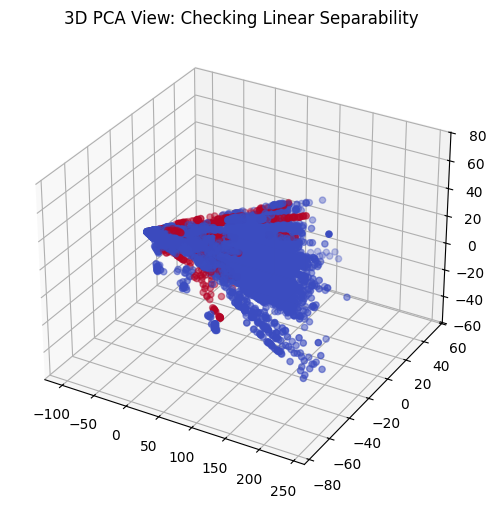

In [17]:
# 3D Visualization
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_pca[:10000,0], train_pca[:10000,1], train_pca[:10000,2], c=train_y[:10000], cmap='coolwarm')
ax.set_title('3D PCA View: Checking Linear Separability')
plt.show()


=== Kernel PCA ===


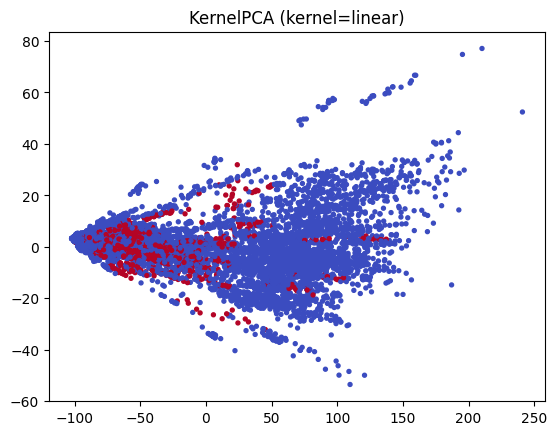

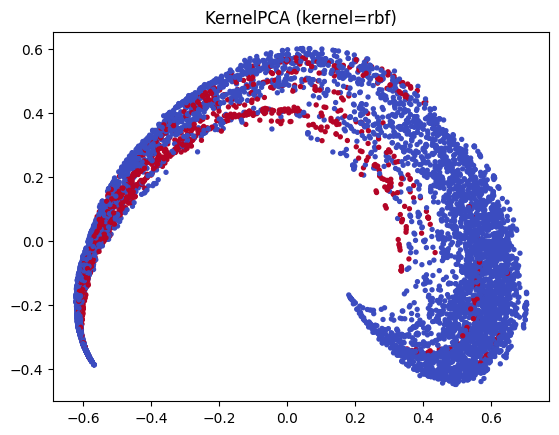

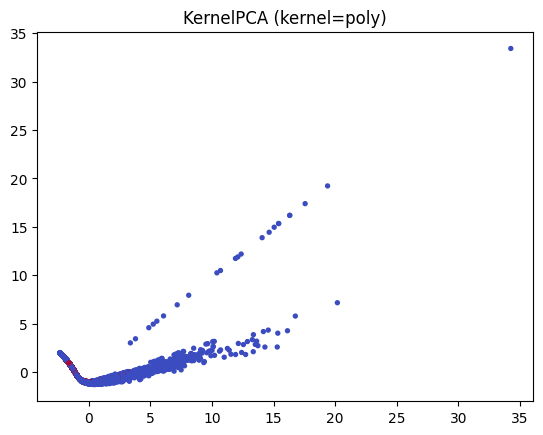

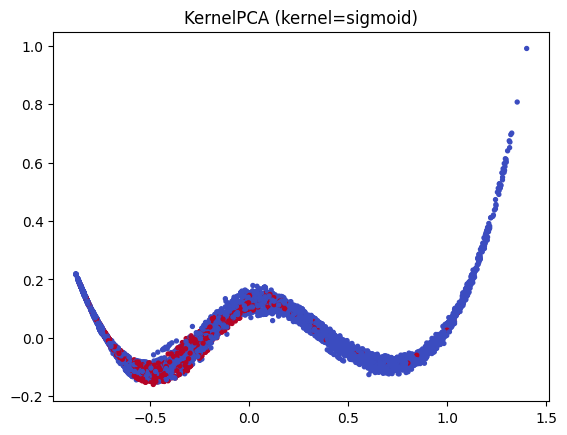

In [18]:
from sklearn.decomposition import PCA, SparsePCA, KernelPCA


print("\n=== Kernel PCA ===")
for kernel in ['linear', 'rbf', 'poly', 'sigmoid']:
    kpca = KernelPCA(n_components=best_n, kernel=kernel, fit_inverse_transform=False, random_state=42)
    kpca_features = kpca.fit_transform(train_X_scaled[:8000])
    plt.scatter(kpca_features[:,0], kpca_features[:,1], c=train_y[:8000], cmap='coolwarm', s=8)
    plt.title(f'KernelPCA (kernel={kernel})')
    plt.show()

<Axes: >

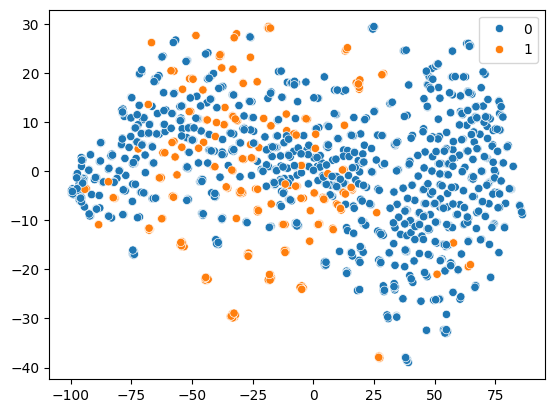

In [19]:
#t-SNE and UMAP embeddings to check cluster overlap:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(train_X_scaled[:2000])
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=train_y[:2000])

In [20]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from xgboost import XGBClassifier

print("\n=== Cross Validation + Hyperparameter Search ===")

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

param_grids = {
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    },
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, None]
    },
    'KNN': {
        'n_neighbors': [3,5,7,9],
        'weights': ['uniform', 'distance']
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    # 'SVC': {
    #     'C': [0.1, 1, 10],
    #     'kernel': ['linear', 'rbf', 'poly']
    # }
}

models = {
    'LogisticRegression': LogisticRegression(max_iter=500),
    'RandomForest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        tree_method='gpu_hist' if torch.cuda.is_available() else 'auto',
        use_label_encoder=False,
        random_state=42
    )
#    'SVC': SVC()
}

results_log = []

for name, model in models.items():
    grid = GridSearchCV(model, param_grids[name], cv=cv, n_jobs=-1, scoring='accuracy', verbose=0)
    grid.fit(train_pca, train_y)
    best_model = grid.best_estimator_
    val_preds = best_model.predict(valid_pca)
    acc = accuracy_score(valid_y, val_preds)
    results_log.append({
        'Model': name,
        'Best_Params': grid.best_params_,
        'CV_Accuracy': grid.best_score_,
        'Validation_Accuracy': acc
    })
    print(f"\n{name} | Best Params: {grid.best_params_}")
    print(f"CV Acc: {grid.best_score_:.4f} | Val Acc: {acc:.4f}")




=== Cross Validation + Hyperparameter Search ===

LogisticRegression | Best Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
CV Acc: 0.8847 | Val Acc: 0.8776

RandomForest | Best Params: {'max_depth': None, 'n_estimators': 200}
CV Acc: 0.9993 | Val Acc: 0.9994

KNN | Best Params: {'n_neighbors': 3, 'weights': 'uniform'}
CV Acc: 0.9997 | Val Acc: 0.9994


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:35:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost | Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
CV Acc: 0.9998 | Val Acc: 0.9996



Summary of Cross-Validation Results:
                Model                                        Best_Params  \
0  LogisticRegression  {'C': 0.01, 'penalty': 'l2', 'solver': 'liblin...   
1        RandomForest           {'max_depth': None, 'n_estimators': 200}   
2                 KNN           {'n_neighbors': 3, 'weights': 'uniform'}   
3             XGBoost  {'colsample_bytree': 0.8, 'learning_rate': 0.2...   

   CV_Accuracy  Validation_Accuracy  
0     0.884667               0.8776  
1     0.999333               0.9994  
2     0.999667               0.9994  
3     0.999800               0.9996  


/tmp/ipython-input-4095887215.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Validation_Accuracy', data=results_df, palette='mako')


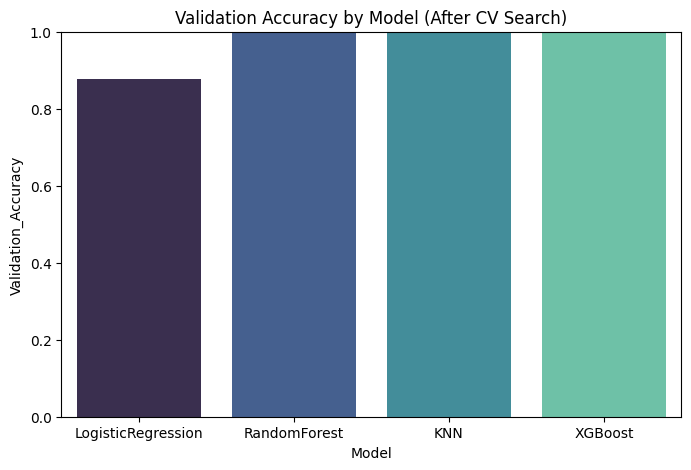

In [21]:
import seaborn as sns

results_df = pd.DataFrame(results_log)
print("\nSummary of Cross-Validation Results:")
print(results_df)

# Plot accuracy comparison
plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='Validation_Accuracy', data=results_df, palette='mako')
plt.title("Validation Accuracy by Model (After CV Search)")
plt.ylim(0,1)
plt.show()

Validation Accuracy: 0.9996

              precision    recall  f1-score   support

         LoS       1.00      1.00      1.00      4064
        NLoS       1.00      1.00      1.00       936

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



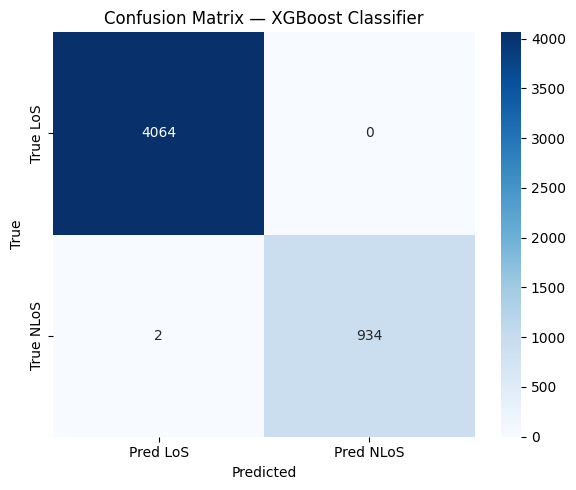

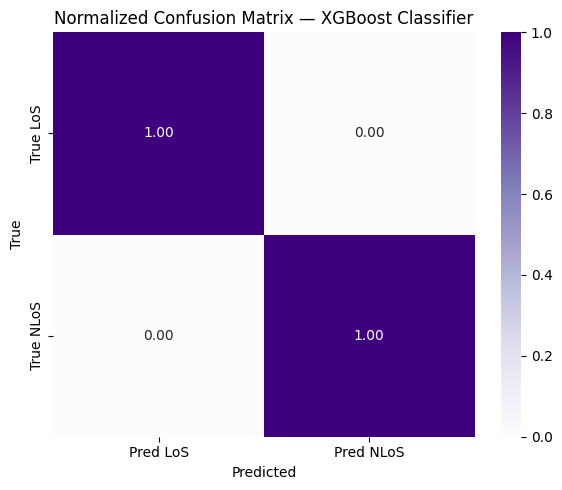

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

# === Get best trained model ===
xgb_best = grid.best_estimator_  # or your trained model variable

# === Predict on validation data ===
y_pred = xgb_best.predict(valid_pca)

# === Compute confusion matrix ===
cm = confusion_matrix(valid_y, y_pred)
acc = accuracy_score(valid_y, y_pred)
print(f"Validation Accuracy: {acc:.4f}\n")

# === Display detailed classification report ===
print(classification_report(valid_y, y_pred, target_names=["LoS", "NLoS"]))

# === Visualize confusion matrix ===
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Pred LoS", "Pred NLoS"], yticklabels=["True LoS", "True NLoS"])
plt.title("Confusion Matrix — XGBoost Classifier")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Optional normalized matrix (proportion form)
cm_norm = cm.astype(np.float64) / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Purples', xticklabels=["Pred LoS", "Pred NLoS"], yticklabels=["True LoS", "True NLoS"])
plt.title("Normalized Confusion Matrix — XGBoost Classifier")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


=== ANN (with Dropout & L2 Regularization) ===
Epoch 01/30 | Loss=0.3811 | ValAcc=0.8840
Epoch 02/30 | Loss=0.2495 | ValAcc=0.9316
Epoch 03/30 | Loss=0.1319 | ValAcc=0.9826
Epoch 04/30 | Loss=0.0636 | ValAcc=0.9948
Epoch 05/30 | Loss=0.0376 | ValAcc=0.9958
Epoch 06/30 | Loss=0.0279 | ValAcc=0.9972
Epoch 07/30 | Loss=0.0204 | ValAcc=0.9974
Epoch 08/30 | Loss=0.0136 | ValAcc=0.9972
Epoch 09/30 | Loss=0.0134 | ValAcc=0.9974
Epoch 10/30 | Loss=0.0111 | ValAcc=0.9980
Epoch 11/30 | Loss=0.0118 | ValAcc=0.9998
Epoch 12/30 | Loss=0.0084 | ValAcc=0.9998
Epoch 13/30 | Loss=0.0075 | ValAcc=0.9994
Epoch 14/30 | Loss=0.0051 | ValAcc=1.0000
Epoch 15/30 | Loss=0.0049 | ValAcc=1.0000
Epoch 16/30 | Loss=0.0042 | ValAcc=1.0000
Epoch 17/30 | Loss=0.0045 | ValAcc=1.0000
Epoch 18/30 | Loss=0.0039 | ValAcc=1.0000
Epoch 19/30 | Loss=0.0027 | ValAcc=1.0000
Epoch 20/30 | Loss=0.0035 | ValAcc=1.0000
Epoch 21/30 | Loss=0.0028 | ValAcc=1.0000
Epoch 22/30 | Loss=0.0027 | ValAcc=1.0000
Epoch 23/30 | Loss=0.0027 | 

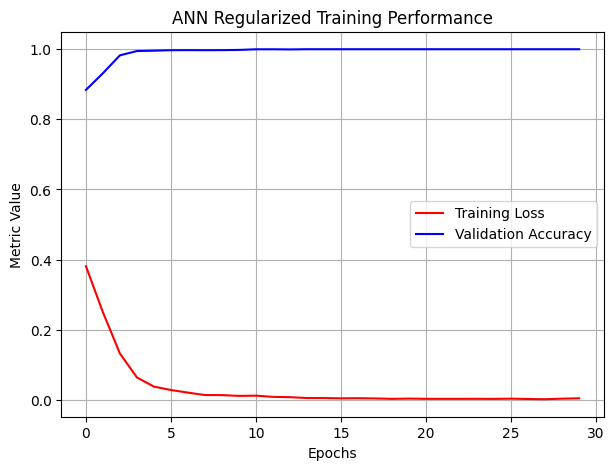

In [23]:
#ANN WITH REGULARIZATION (Dropout + Weight Decay)

class ANNClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

input_dim = train_pca.shape[1]
ann = ANNClassifier(input_dim).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(ann.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization

X_train_t = torch.tensor(train_pca, dtype=torch.float32).to(device)
y_train_t = torch.tensor(train_y.reshape(-1, 1), dtype=torch.float32).to(device)
X_valid_t = torch.tensor(valid_pca, dtype=torch.float32).to(device)
y_valid_t = torch.tensor(valid_y.reshape(-1, 1), dtype=torch.float32).to(device)

epochs, batch_size = 30, 256
train_loss_log, val_acc_log = [], []

print("\n=== ANN (with Dropout & L2 Regularization) ===")
for epoch in range(epochs):
    ann.train()
    perm = torch.randperm(X_train_t.size(0))
    total_loss = 0
    for i in range(0, X_train_t.size(0), batch_size):
        idx = perm[i:i+batch_size]
        xb, yb = X_train_t[idx], y_train_t[idx]
        optimizer.zero_grad()
        out = ann(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(xb)
    train_loss = total_loss / X_train_t.size(0)
    ann.eval()
    with torch.no_grad():
        preds = (ann(X_valid_t) >= 0.5).float()
        acc = (preds.eq(y_valid_t).sum() / len(y_valid_t)).item()
    train_loss_log.append(train_loss)
    val_acc_log.append(acc)
    print(f"Epoch {epoch+1:02d}/{epochs} | Loss={train_loss:.4f} | ValAcc={acc:.4f}")

# Plot training curves
plt.figure(figsize=(7,5))
plt.plot(range(epochs), train_loss_log, label='Training Loss', color='red')
plt.plot(range(epochs), val_acc_log, label='Validation Accuracy', color='blue')
plt.xlabel("Epochs"); plt.ylabel("Metric Value")
plt.title("ANN Regularized Training Performance")
plt.legend(); plt.grid(True); plt.show()


=== FINAL ANN RESULTS ===
Validation Accuracy: 1.0000
Confusion Matrix:
 [[4064    0]
 [   0  936]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4064
           1       1.00      1.00      1.00       936

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



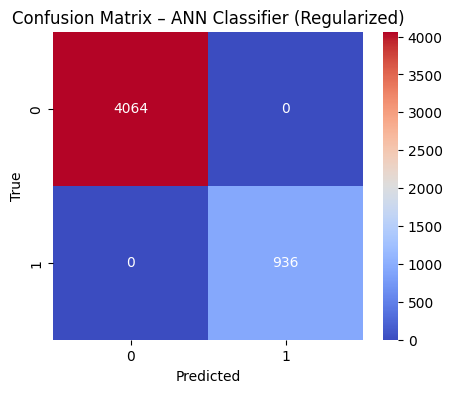


✅ Experiments complete.


In [24]:
# Final Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

ann.eval()
with torch.no_grad():
    preds_final = (ann(X_valid_t) >= 0.5).float().cpu().numpy()

acc_final = accuracy_score(valid_y, preds_final)
cm = confusion_matrix(valid_y, preds_final)

print("\n=== FINAL ANN RESULTS ===")
print(f"Validation Accuracy: {acc_final:.4f}")
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(valid_y, preds_final))

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.title("Confusion Matrix – ANN Classifier (Regularized)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

print("\n✅ Experiments complete.")

###  CSI Processing: Normalize to [0,1]